<style>
@import url(https://www.numfys.net/static/css/nbstyle.css);
</style>
<a href="https://www.numfys.net"><img class="logo" /></a>

# Calling Fortran(95) routines from a Python Script

### Modules - Python Packages
<section class="post-meta">
By Magnus H-S Dahle, Henning G. Hugdal, Håkon W. Ånes and Peter Berg
</section>
Last edited: January 25th 2018 
___

## Introduction

The choice of programming language can be extensively difficult, especially considering computational effectiveness against implementation time and effort. While scripting languages like <i><b>MATLAB</b></i> and <i><b>Python</b></i> may provide intuitive code which is fast to implement, compiled languages like <i><strong>C/C++</strong></i> and <i><strong>Fortran</strong></i> yield superior computational speed. Within this example, we'll show that it is in fact possible to obtain the very best of both worlds. At least to some extent.

In the following example, we'll make use of the Fortran to Python package <strong>F2PY</strong>, which enables creating and compiling a Fortran routine, before converting it to a Python Module which can be imported to any Python script! This is a powerful tool giving us the possibility to develop easy written code in <i>Python</i>, but leaving more computational demanding parts of our program to a more capable Fortran routine.

## The Fortran-to-Python module (F2PY)

<strong>Note:</strong> If you are not familiar with the F2PY module, please read the guide on the <a href="http://www.numfys.net/howto/">how to page</a>. It shows, with examples, how to write subroutines and functions with Fortran, before compiling and converting them to an importable Python module.

Within this short example, we'll show exactly how powerful a tool <strong>F2PY</strong> may be. By conducting a numerical integration, applying the trapezoidal method described in the following section, we will calculate the electric potential from a non-uniformly, electrically charged rod. First with a pure Python script, then by letting a Fortran routine do the hard work using F2PY, before comparing efficiency of the two approaches. 

## Numerical Integration - The Trapezoidal Rule

Note that the Trapezoidal and Simpson methods are explained in great detail in the [Numerical Integration notebook](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/numerical_integration.ipynb), whereas here, we will give only a very brief description: The Trapozoidal rule is a method for calculating an approximated, definite integral by assuming the area under the integrand $f(x)$ to be a trapezoid, and thus evaluate its area:

$$
\int \limits_a^b f(x) \textrm{d}x \approx (b-a)\left[ \frac{f(a)+f(b)}{2}\right].
$$

Obviously, the less the derivatives of $f(x)$ vary on the interval $[a,b]$, the more accurate the method is. Moreover, the interval should be divided into $N$ separate and shorter subintervals, which are added together,

$$
\int \limits_a^b f(x) \textrm{d}x = \sum \limits_{n=0}^{N-1} \int \limits_{a+n\Delta}^{a+(n+1)\Delta} f(x)\,\textrm{d}x.
$$

For simplicity, we'll apply uniform subintervals, $\Delta = (b-a)/N$. Using the convention $x_n = a + n\Delta$, we now have

$$
\int \limits_a^b f(x) \textrm{d}x \approx \sum \limits_{n=0}^{N-1} (x_{n+1}-x_n) \left[ \frac{f(x_n) + f(x_{n+1})}{2} \right],
$$

where $(x_{n+1}-x_n)$ can be replaced by $\Delta$, having applied equally spaced subintervals. Note that the constant $\Delta/2$ can be moved outside the summation to increase effciency by decreasing the number of operations within each loop-iteration in a computer program (or script).

In [1]:
# Import Modules
%matplotlib inline
#from __future__ import print_function
import numpy as np
import math as m
import matplotlib.pyplot as plt
import time

In [2]:
# AN EASY EXAMPLE INTEGRATING f(x)
# Using the Trapezoidal Method

def function(x):
    return 2*x**2 + 1


# Integrate f(x) using the trapezoidal rule,
a = 0.0  # lower bound
b = 2.0  # upper bound
N = 300  # no. of sub intervals / resolution
D = (b - a)/N # delta, length of subinterval

Integral = 0.0 # the resulting integral
x = a # initial value

for i in range(N):
    Integral = Integral + (function(x + D) + function(x))
    x = x + D
    
Integral = Integral * 0.5*D

print("Approximated Integral  = ", round(Integral, 2))
print("Exact Integral = 22/3 ~= ", round(22.0/3.0, 2))

Approximated Integral  =  7.33
Exact Integral = 22/3 ~=  7.33


## A More Computational Demanding, But Still Quite Simple Problem

Consider an infinitely thin rod of length $L=1\,\mathrm{m}$ placed along the $x$-axis on the interval $[0,1]$. The rod has a non-uniform charge distribution given by

$$
\lambda(x) = \lambda_0x,
$$

where $\lambda_0=0.3\,\mathrm{C/m^2}$ is a constant. We now want to find the electrical (scalar) potential along the line $x\in[0,1]$ at $y=1\,\mathrm{m}$. That is, the line parallell to, but separated $1\,\mathrm{m}$ from, the rod.

### Exact Solution

This problem can be given an exact solution (at least for as long as we keep $\lambda(x)$ simple), which we will use for comparing with our later numerical solution. In general, the electrical potential $\varphi$ at any point $(x,y)$, not at the rod, for this system can be expressed by

$$
% http://www.wolframalpha.com/input/?i=integral+%28++%28a_0+*+x+*+dx%29%2F%28sqrt%28+%28z-x%29^2+%2B+%281%29^2+%29%29++%29+
\varphi(x,y) = \frac{1}{4\pi \varepsilon_0} \int \limits_0^L \frac{\lambda(x')\textrm{d}x'}{\sqrt{(x-x')^2 + (y-y')^2}}.
$$

We introduce $z \equiv x'/L$, ($\textrm{d}x' = \textrm{d}z\cdot L$) in order to make the integral dimensionless. Hence,

$$
\frac{4\pi \varepsilon_0}{\lambda_0} \varphi(x,1) =  \int \limits_0^1 \frac{z L^2 \cdot \textrm{d}z}{\sqrt{(x-z L)^2 + (y-y')^2}}.
$$


Inserting $y=1$ and $y'=0$ and dragging $L$ to the LHS gives

$$
\frac{4\pi \varepsilon_0}{\lambda_0 L} \varphi(x,1) =  \int \limits_0^1 \frac{z \cdot \textrm{d}z}{\sqrt{\left(\frac{x}{L}-z \right)^2 + 1}}
$$

with solution

$$
\frac{4\pi \varepsilon_0}{\lambda_0 L} \varphi(x,1) = \left[ \sqrt{\left(\frac{x}{L}-z\right)^2 + 1} - \frac{x}{L}\operatorname{sinh}^{-1}\left( \frac{x}{L}-z \right) \right]_{0}^{L},
$$

as computed by <a href="http://www.wolframalpha.com/input/?i=integral+%28+z%2Fsqrt%28%28a-z%29^2+%2B+1%29+dz%29+">WolframAlpha</a>.

In [3]:
# THE EXACT SOLUTION
# OBS: Takes x/L as argument, instead of only x

Phi_Res = 1000 # Resolution in phi: no. of times to perform the integral
Int_Res = 1000 # Resolution in the integral: Trapezoidal method

L = 1.0

x_list   = np.linspace(0, L, Phi_Res)
phi_x_ex = np.zeros(Phi_Res)

    
def ExactSolution(xL):
    Term1 = m.sqrt((xL - L)**2 + 1) - xL*m.asinh(xL - L) # z = L
    Term2 = m.sqrt((xL - 0)**2 + 1) - xL*m.asinh(xL - 0) # z = 0
    return Term1 - Term2
    
for i in range(Phi_Res):
    phi_x_ex[i] = ExactSolution(x_list[i]/L)

<strong>Now, what makes this problem computational demanding?</strong> Analytically, we obtain an expression for $\varphi$ for any $x$-value. Numerically, we will need to compute the integral for <i>all</i> $x$-values. That is, depending on what resolution we want for $\varphi$, the integral will have to be solved quite a lot of times. If $\lambda(x)$ becomes complicated, highly oscillating and/or has highly varying derivatives, an exact (or analytical) solution may not be possible to obtain, and even the numerical integrator we implement might end up in serious trouble. Always keep in mind that no numerical method is perfect, but all have their strengths and weaknesses.

### Numerical Solution - Pure Python

We wish to calculate
$$
\varphi(x,y) \bigg|_{x\in[0,1],\,y=1}.
$$

Computers have no concept of physical units, thus, we adopt the dimensionless integral obtained in the exact solution,

$$
\frac{4\pi \varepsilon_0}{\lambda_0} \cdot \varphi(x,1) =  \int \limits_0^1 \frac{ z \cdot \operatorname{d}z}{\sqrt{\left(\frac{x}{L}-z\right)^2 + 1}}.
$$

We then apply the Trapezoidal rule, evaluating this integral for multiple values of $x\in[0,1]$.

In [4]:
# CONSTANTS
PI      = np.pi     # radians [dimless]
L       = 1.0       # meters
lambda0 = 0.3       # Coloumb/meters
eps0    = 8.854e-11 # Farads/meters

Note that we won't really be using these constants (except $L$).
We will instead plot the LHS of the above integral as a function of $x$
Non-dimensionalizing as done above is extremly helpful in computational physics, as
really large/small numbers/constants may cause trouble within a machine
of finite numbering resolution.

Elapsed time (s):  4.22


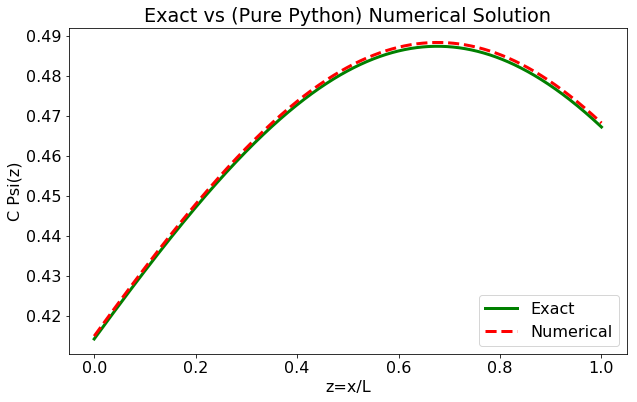

In [5]:
phi_x    = np.zeros(Phi_Res) # initialize to zero

z_list   = np.linspace(0, L, Int_Res)

dz       = z_list[1] - z_list[0] # delta_z

def chargeDens(z_):
    # lambda= lambda0 * x' = (lambda0*L)*z
    # and lambda0*L is taken outside the integral
    # such that we're left with:
    return z_

def integrand(z_, x_):
    return (chargeDens(z_)) / (np.sqrt((x_/L - z_)**2 + 1))


start = time.time()
i = 0
for x in x_list: # Perform the integral for all x-values
    for z in z_list:
        phi_x[i] = phi_x[i] + (integrand(z + dz, x) + integrand(z, x))
    phi_x[i] = phi_x[i] * 0.5 * dz
    i = i + 1
end = time.time()
purePythonTime = end-start
print("Elapsed time (s): ", round(purePythonTime,3))


fontSettings = {'size' : 16 }
plt.rc('font', **fontSettings)

plt.figure(figsize=(10, 6))
plt.title('Exact vs (Pure Python) Numerical Solution')
plt.ylabel('C Psi(z)')
plt.xlabel('z=x/L')
plt.plot(x_list,phi_x_ex,color='g', linestyle='-', linewidth=3.0, label='Exact')
plt.plot(x_list,phi_x,   color='r', linestyle='--',linewidth=3.0, label='Numerical')
plt.legend(loc=4)
plt.show()

### Numerical Solution - F2PY

Again, considering the dimensionless integral,

$$
\frac{4\pi \varepsilon_0}{\lambda_0} \cdot \varphi(x,1) =  \int \limits_0^1 \frac{ z \cdot \operatorname{d}z}{\sqrt{\left(\frac{x}{L}-z\right)^2 + 1}},
$$

we now run the equivalent code as in the section above, but we have reimplemented both <i>for-loops</i>, and all calculation performed within them in a F2PY-module named <strong>TrapIntg_elRod</strong>. Note that the actual module, is a file named <i>TrapIntg_elRod.cpython-35m-x86_64-linux-gnu.so</i>, generated by <strong>F2PY</strong> and placed in the same directory as the Python script using it. We have included the Fortran-code itself in the very last section.

--------------------------------
This module 'TrapIntg_elRod' is auto-generated with f2py (version:2).
Functions:
  phi_x = trapezoidalintegrator(phi_res,int_res,l)
.
--------------------------------
Elapsed time (s):  0.0046


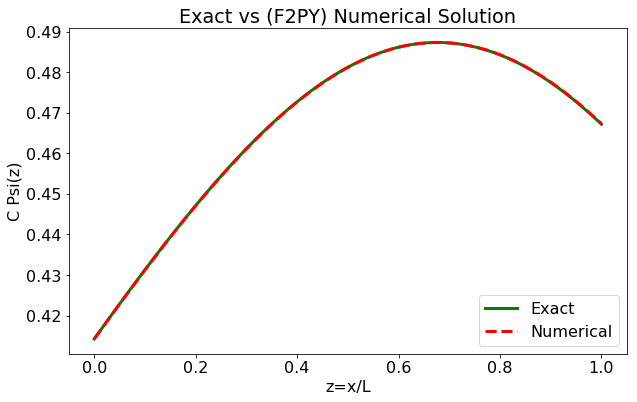

In [9]:
import TrapIntg_elRod as TIeR
# The Python module containing compiled Fortran code.
# The Fortran code is included at the very end of this Example.


# Check the documentation of out Fortran Module:
print("--------------------------------")
print(TIeR.__doc__)
print("--------------------------------")


start  = time.time()
phi_x  = TIeR.trapezoidalintegrator(np.array(Phi_Res), np.array(Int_Res), L)
end    = time.time()

F2PYtime = end-start
print("Elapsed time (s): ", round(F2PYtime,4))

plt.figure(figsize=(10,6))
plt.title('Exact vs (F2PY) Numerical Solution')
plt.ylabel('C Psi(z)')
plt.xlabel('z=x/L')
plt.plot(x_list,phi_x_ex,color='g', linestyle='-', linewidth=3.0, label='Exact')
plt.plot(x_list,phi_x,   color='r', linestyle='--',linewidth=3.0, label='Numerical')
plt.legend(loc=4)
plt.show()

Do note that the error in solution produced by the F2PY-solver is smaller than the equivalent from the one implemented in pure Python. This has to do with how the machine adds (sums up) floating point numbers which suffers from a truncation error. As Fortran is a numerical programming language, it has been optimized to minimize this error.

## So, what's the difference?

For the equivalent computational work, the pure Python script had en elapsed time of order 1 second, compared to the mixed Fortran-Python program's time of order 0.001 seconds. That implies a factor of 1000! Or, in other words, the mixed script completed the same amount of work using only 0.1 percent of the time! Better approximated ratios are printed below,

In [8]:
print("PurePythonTime / F2PYtime ~= ", round(purePythonTime/F2PYtime))
print("\nThe elapsed F2PY-time constitutes only",round((F2PYtime/purePythonTime)*100,2),
      "% of the elapsed pure Python time.")

PurePythonTime / F2PYtime ~=  927

The elapsed F2PY-time constitutes only 0.11 % of the elapsed pure Python time.


If our program using <strong>F2PY</strong> was to handle a rather computational demanding problem resulting it to run for 1 hour, then the pure Python version could be expected to have a running time close to 40 days!

## The Fortran Code Used in the Above Example

We give the Fortran(95) subroutine below, which was converted into a Python Module with <strong>F2PY</strong>, and used to solve the above computatonal problem.

``` fortran
subroutine TrapezoidalIntegrator(phi_x, phi_res, int_res, L)

implicit none

! IN-/OUTPUT
integer, intent(in)  :: phi_res, int_res
real, intent(in) :: L
real, intent(out) :: phi_x(phi_res)

! OTHER VARs
integer  :: i, j 
real :: x, z, dx, dz, intg, chDens        

dz = (L - 0.0)/real(int_res)
dx = (L - 0.0)/real(phi_res)
z = 0.0
x = 0.0

do i = 1, phi_res       ! for every x ..
    do j = 1, int_res   ! .. integrate
        chDens   = z 
        intg     = chDens / ( sqrt( (x/L - z)**2.0 + 1.0) )
        phi_x(i) = phi_x(i) + intg


        z = z+dz
        chDens   = z
        intg     = chDens / (sqrt(  (x/L - z)**2.0 + 1.0 ) )
        phi_x(i) = phi_x(i) + intg

     end do
     phi_x(i) = phi_x(i) * (0.5*dz)
     x = x+dx
     z = 0.0
end do

return
end subroutine

 

```